# Lesson 9: Segmentation

- In the classroom, the libraries are already installed for you.
- If you would like to run this code on your own machine, you can install the following:

```
    !pip install transformers
    !pip install gradio
    !pip install timm
    !pip install torchvision
```

- Here is some code that suppresses warning messages.

## the thing about SAM is: to build a foundational model for segmentation taht can generalize well to new image distributions, scalable, propmtable, and edge detection etc. It also has an emphasis on zero-shot setting,

## also, through prompt engineering, we can adapt to new NLP tasks without needing fine-tuning.

## masks: a mask refers to a binary or probabilistic map that highlights specific regions of an image, separating the objects or areas of interest from the background

## Each mask represents a prediction made by SAM about the boundaries of an object or a region in the image based on the user’s input, or prompt

In [2]:
# !pip install transformers
# !pip install gradio
# !pip install timm
# !pip install torchvision

In [3]:
from transformers.utils import logging
logging.set_verbosity_error()

### Mask Generation with SAM

The [Segment Anything Model (SAM)](https://segment-anything.com) model was released by Meta AI.

In [4]:
from transformers import pipeline

In [5]:
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/38.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Info about [Zigeng/SlimSAM-uniform-77](https://huggingface.co/Zigeng/SlimSAM-uniform-77)

In [6]:
from PIL import Image

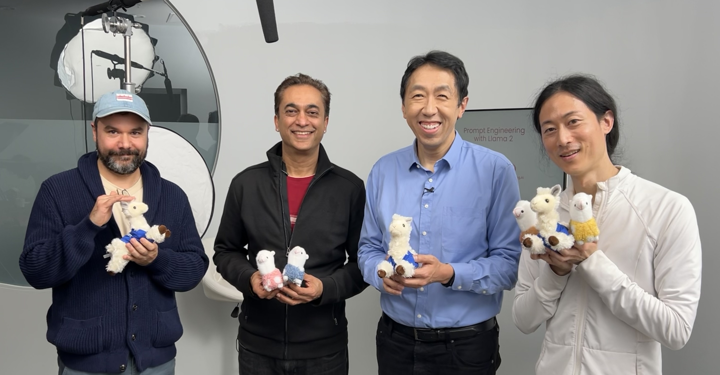

In [8]:
raw_image = Image.open('meta_llamas.jpg')
raw_image.resize((720, 375))

- Running this will take some time
- The higher the value of 'points_per_batch', the more efficient pipeline inference will be

In [9]:
output = sam_pipe(raw_image, points_per_batch=32)

In [12]:
type(output)

dict

In [14]:
from helper_9 import show_pipe_masks_on_image

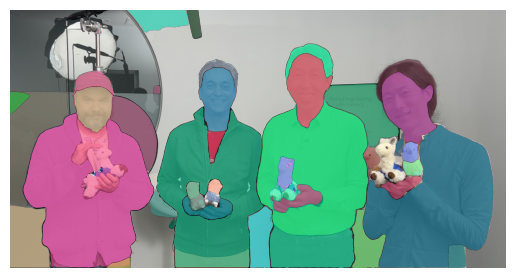

In [15]:
show_pipe_masks_on_image(raw_image, output)

_Note:_ The colors of segmentation, that you will get when running this code, might be different than the ones you see in the video.

### Faster Inference: Infer an Image and a Single Point

In [16]:
from transformers import SamModel, SamProcessor

In [18]:
model = SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

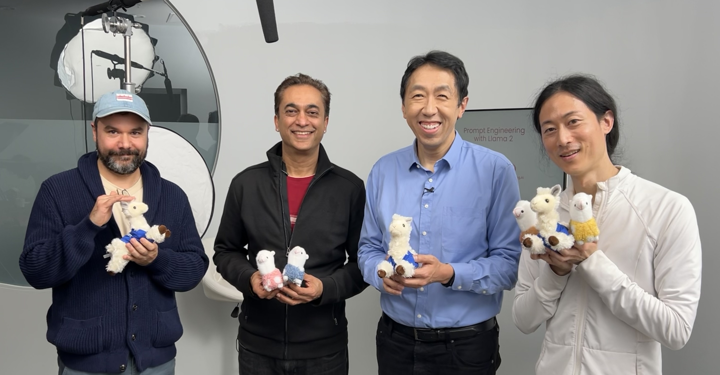

In [19]:
raw_image.resize((720, 375))

- Segment the blue shirt Andrew is wearing.
- Give any single 2D point that would be in that region (blue shirt).

In [20]:
input_points = [[[1600, 700]]]

- Create the input using the image and the single point.
- `return_tensors="pt"` means to return PyTorch Tensors.

In [21]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

- Given the inputs, get the output from the model.

In [22]:
import torch

In [23]:
with torch.no_grad():
    outputs = model(**inputs)

In [24]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

 Length of `predicted_masks` corresponds to the number of images that are used in the input.

In [25]:
len(predicted_masks)

1

- Inspect the size of the first ([0]) predicted mask

In [26]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 1500, 2880])

In [27]:
outputs.iou_scores

tensor([[[0.9583, 0.9551, 0.9580]]])

In [28]:
from helper_9 import show_mask_on_image

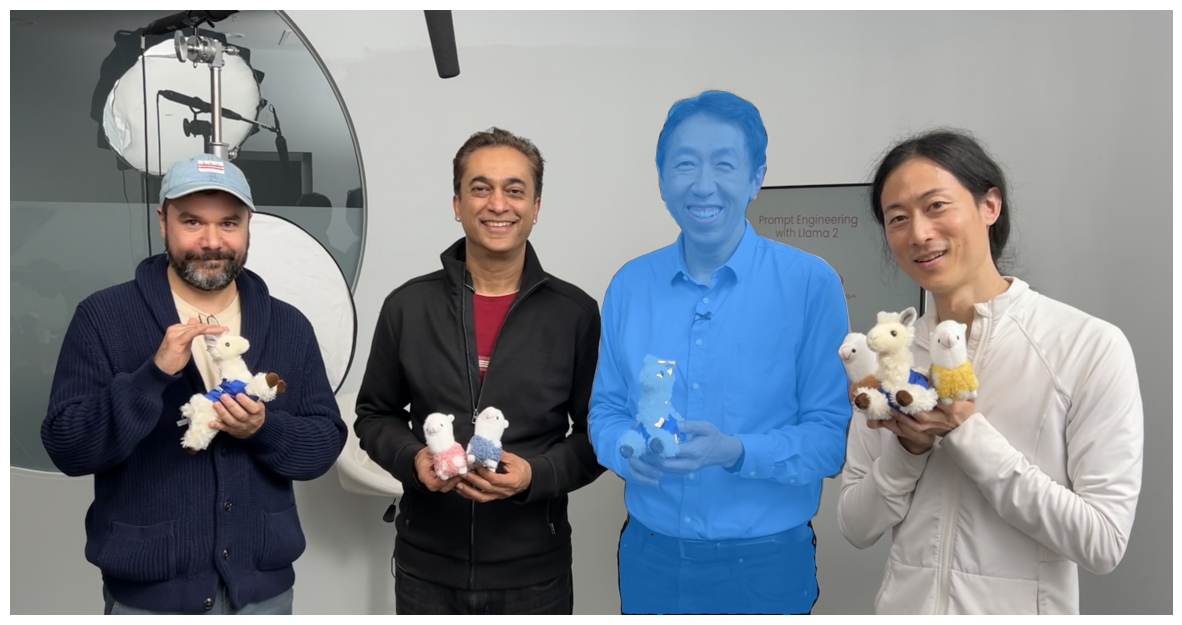

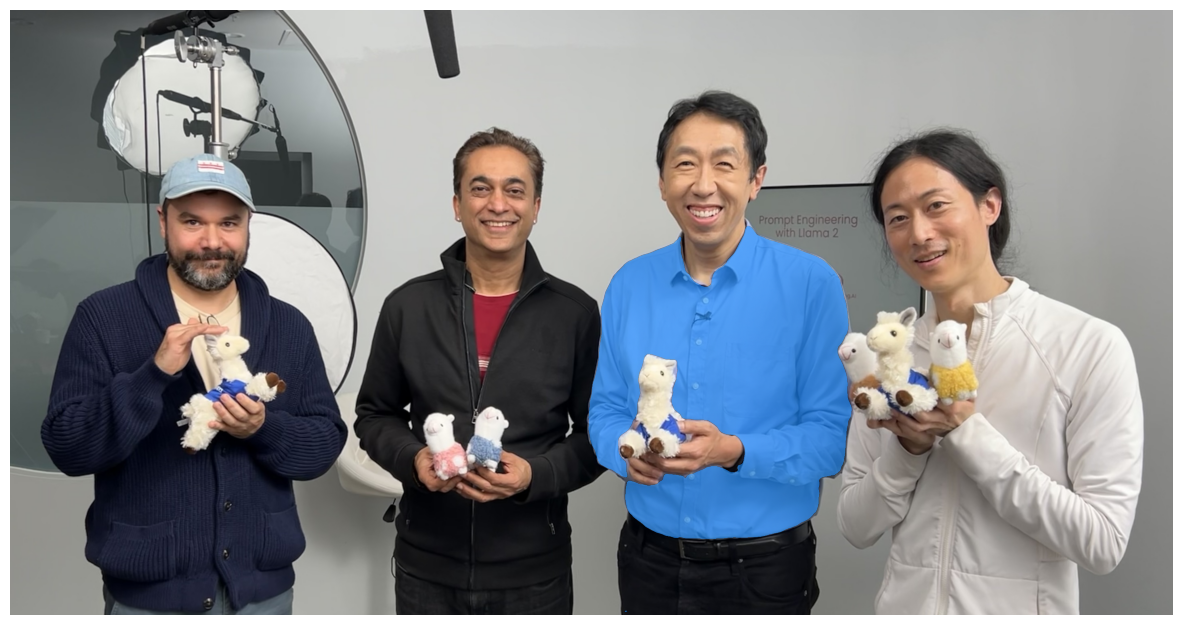

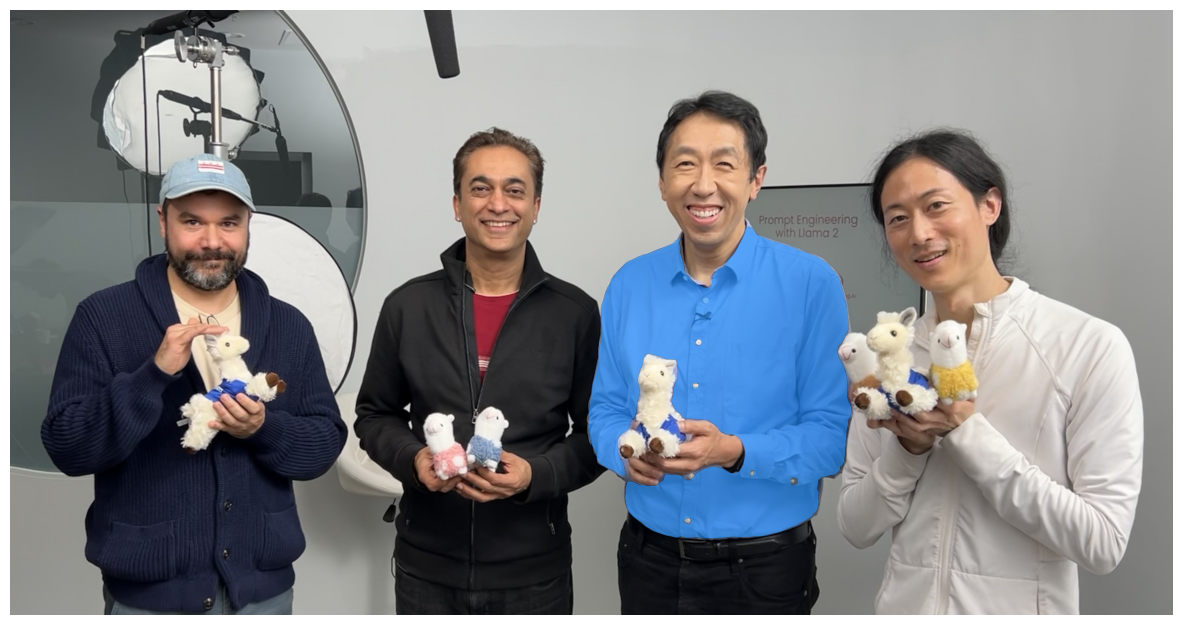

In [29]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

## Depth Estimation with DPT

- This model was introduced in the paper [Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413) by Ranftl et al. (2021) and first released in [isl-org/DPT](https://github.com/isl-org/DPT).

In [30]:
depth_estimator = pipeline(task="depth-estimation",
                        model="Intel/dpt-hybrid-midas")

config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

Info about ['Intel/dpt-hybrid-midas'](https://huggingface.co/Intel/dpt-hybrid-midas)

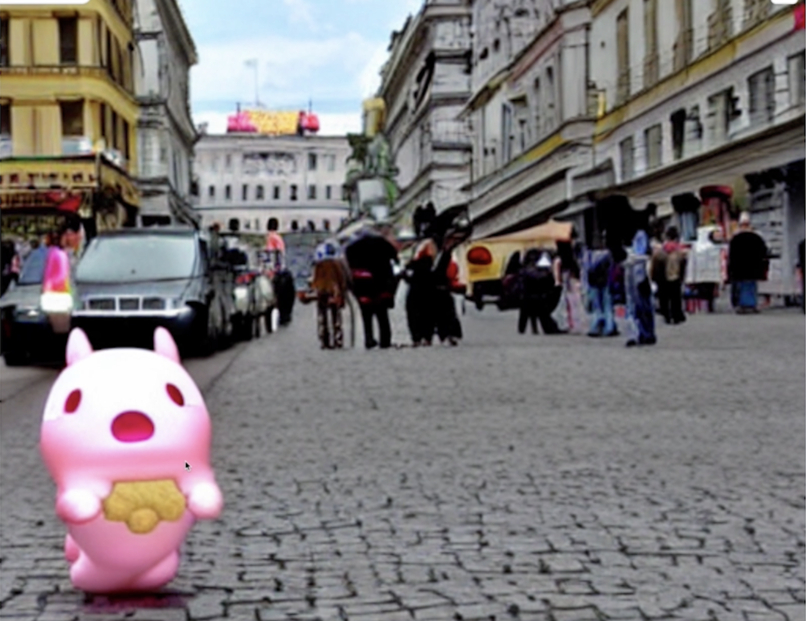

In [31]:
raw_image = Image.open('gradio_tamagochi_vienna.png')
raw_image.resize((806, 621))

- If you'd like to generate this image or something like it, check out the short course on [Gradio](https://www.deeplearning.ai/short-courses/building-generative-ai-applications-with-gradio/) and go to the lesson "Image Generation App".

In [32]:
output = depth_estimator(raw_image)

In [33]:
output

{'predicted_depth': tensor([[[ 248.4070,  252.1828,  256.9171,  ...,  595.8297,  591.8107,
            471.2295],
          [ 247.3371,  254.8536,  257.9679,  ...,  596.0247,  589.0451,
            594.1439],
          [ 259.7675,  259.5481,  261.4167,  ...,  597.6286,  595.3369,
            595.7493],
          ...,
          [3014.1089, 3018.4839, 3019.1711,  ..., 3275.2754, 3269.3459,
           3268.8362],
          [3041.5544, 3040.2783, 3044.4622,  ..., 3280.7471, 3289.3652,
           3274.8696],
          [3039.7483, 3056.0349, 3052.9739,  ..., 3301.9993, 3298.1875,
           3286.9126]]]),
 'depth': <PIL.Image.Image image mode=L size=1612x1242>}

- Post-process the output image to resize it to the size of the original image.

In [34]:
output["predicted_depth"].shape

torch.Size([1, 384, 384])

In [35]:
output["predicted_depth"].unsqueeze(1).shape
# to match the expected input shape of functions or models that require a channel dimension

torch.Size([1, 1, 384, 384])

In [36]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [37]:
prediction.shape

torch.Size([1, 1, 1242, 1612])

In [38]:
raw_image.size[::-1],

((1242, 1612),)

In [39]:
prediction

tensor([[[[ 248.1577,  248.2614,  248.7576,  ...,  468.0627,  447.0034,
            442.8550],
          [ 248.0309,  248.1445,  248.6918,  ...,  477.7614,  458.3928,
            454.5768],
          [ 247.0836,  247.2386,  247.9993,  ...,  508.8532,  494.9498,
            492.2080],
          ...,
          [3040.0381, 3040.3979, 3042.2317,  ..., 3285.1279, 3283.1458,
           3282.7566],
          [3037.8704, 3038.3865, 3041.0278,  ..., 3288.0640, 3286.3352,
           3285.9907],
          [3037.5505, 3038.1133, 3040.9949,  ..., 3289.0688, 3287.3901,
           3287.0542]]]])

- Normalize the predicted tensors (between 0 and 255) so that they can be displayed.

In [40]:
import numpy as np

In [50]:
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

# basiclaly, change the output of a segmentation mask into an image format
# it reshapes the output, scales its values to fit the 0-255 range for image pixels
# then change the data to an 8-bit integer
# and then creates an image
# so allows the model’s output to be visualized or saved as an image

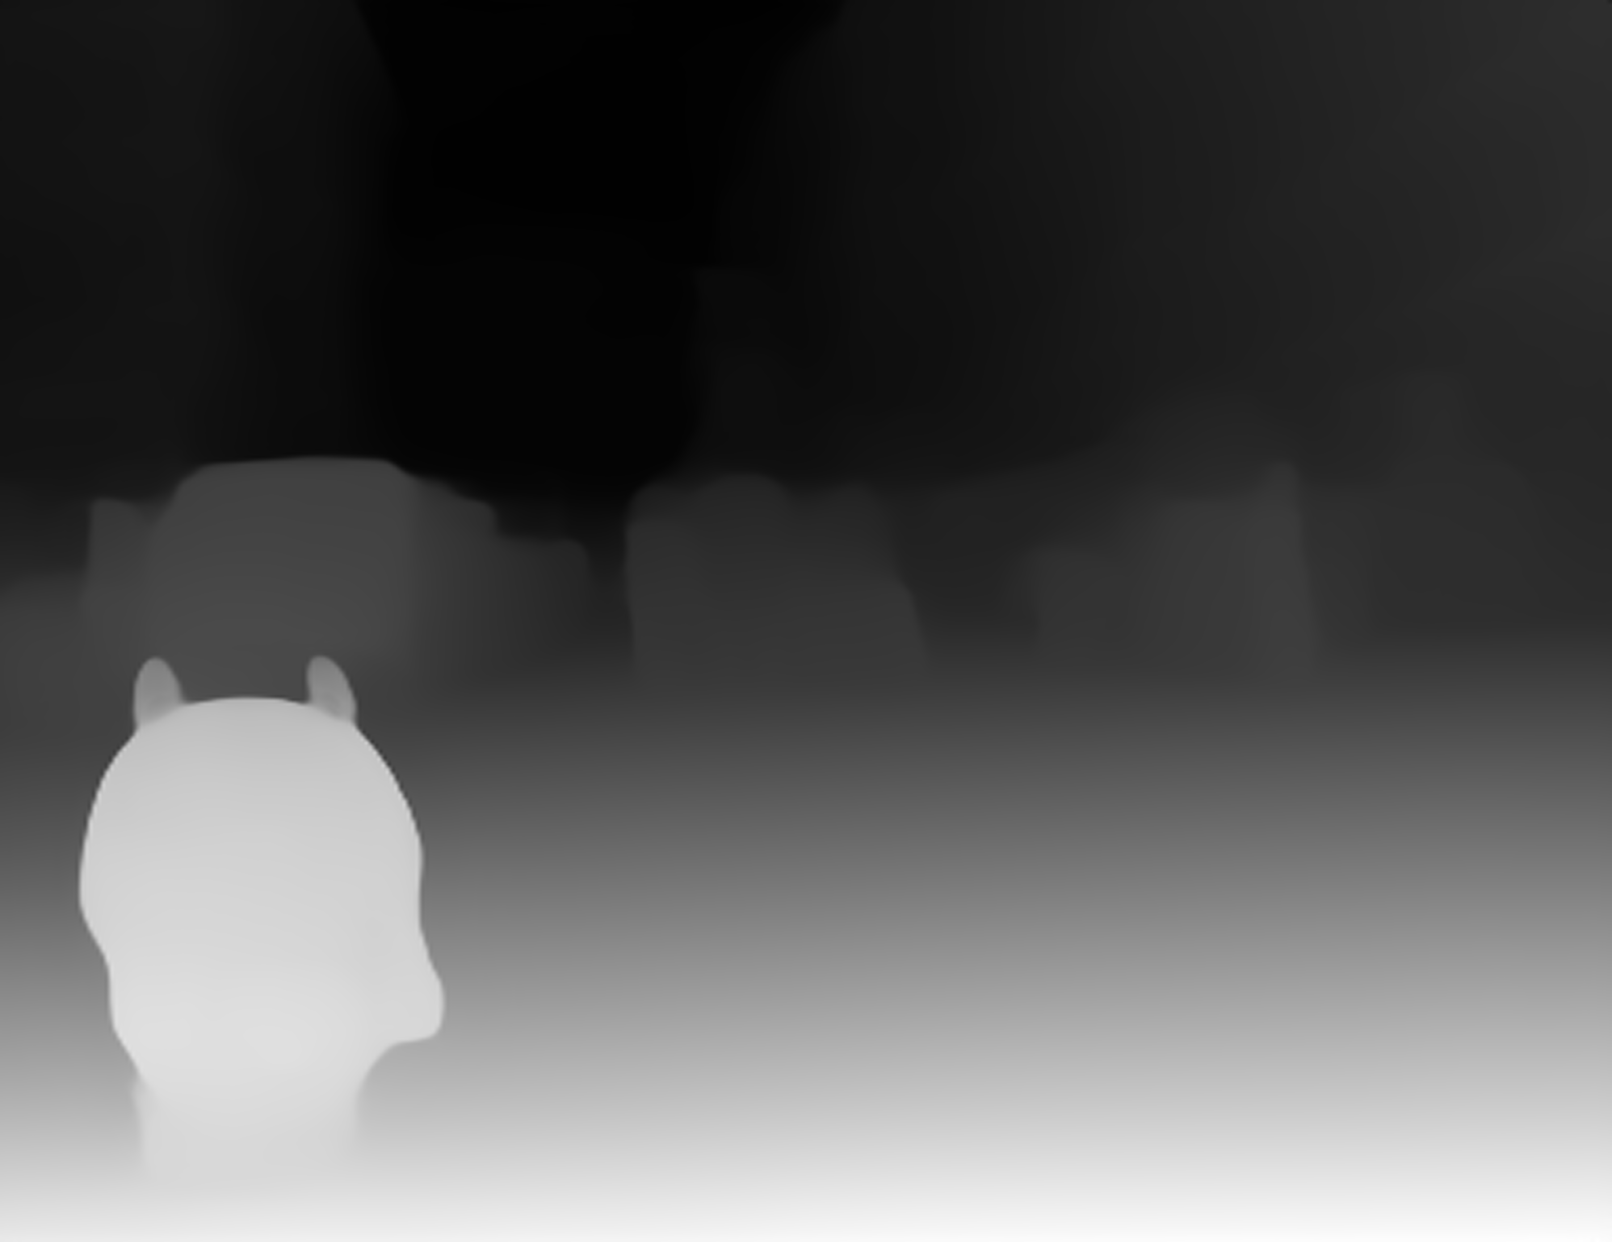

In [42]:
depth

### Demo using Gradio

### Troubleshooting Tip
- Note, in the classroom, you may see the code for creating the Gradio app run indefinitely.
  - This is specific to this classroom environment when it's serving many learners at once, and you won't wouldn't experience this issue if you run this code on your own machine.
- To fix this, please restart the kernel (Menu Kernel->Restart Kernel) and re-run the code in the lab from the beginning of the lesson.

In [43]:
import os
import gradio as gr
from transformers import pipeline

In [44]:
def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

# What interpolate does:
# downsample: increasing the size of the tensor, the function generates new pixel values
# by "interpolating" between the existing ones (such as bilinear, bicubic interpolation).
# upsampled_tensor = F.interpolate(input_tensor, size=(8, 8), mode='bilinear', align_corners=False)

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [45]:
iface = gr.Interface(launch,
                     inputs=gr.Image(type='pil'),
                     outputs=gr.Image(type='pil'))

In [48]:
iface.launch(share=True, server_port=int(8070))

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b1ede89500b740fe05.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [49]:
iface.close()

Closing server running on port: 8070


### Close the app
- Remember to call `.close()` on the Gradio app when you're done using it.

### Try it yourself!
- Try this model with your own images!

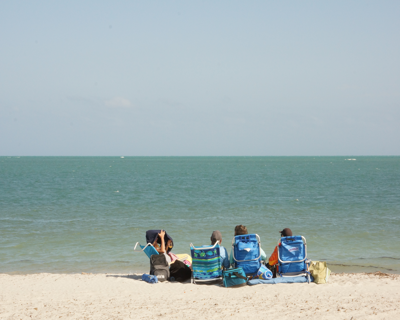

In [60]:
# raw_image = Image.open('my_pic.jpg')
# raw_image.resize((400, 320))

In [53]:
# output = depth_estimator(raw_image)

In [55]:
raw_image = Image.open('my_pic.jpg')
raw_image.resize((400, 320))
output = depth_estimator(raw_image)
output["predicted_depth"].shape
output["predicted_depth"].unsqueeze(1).shape
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

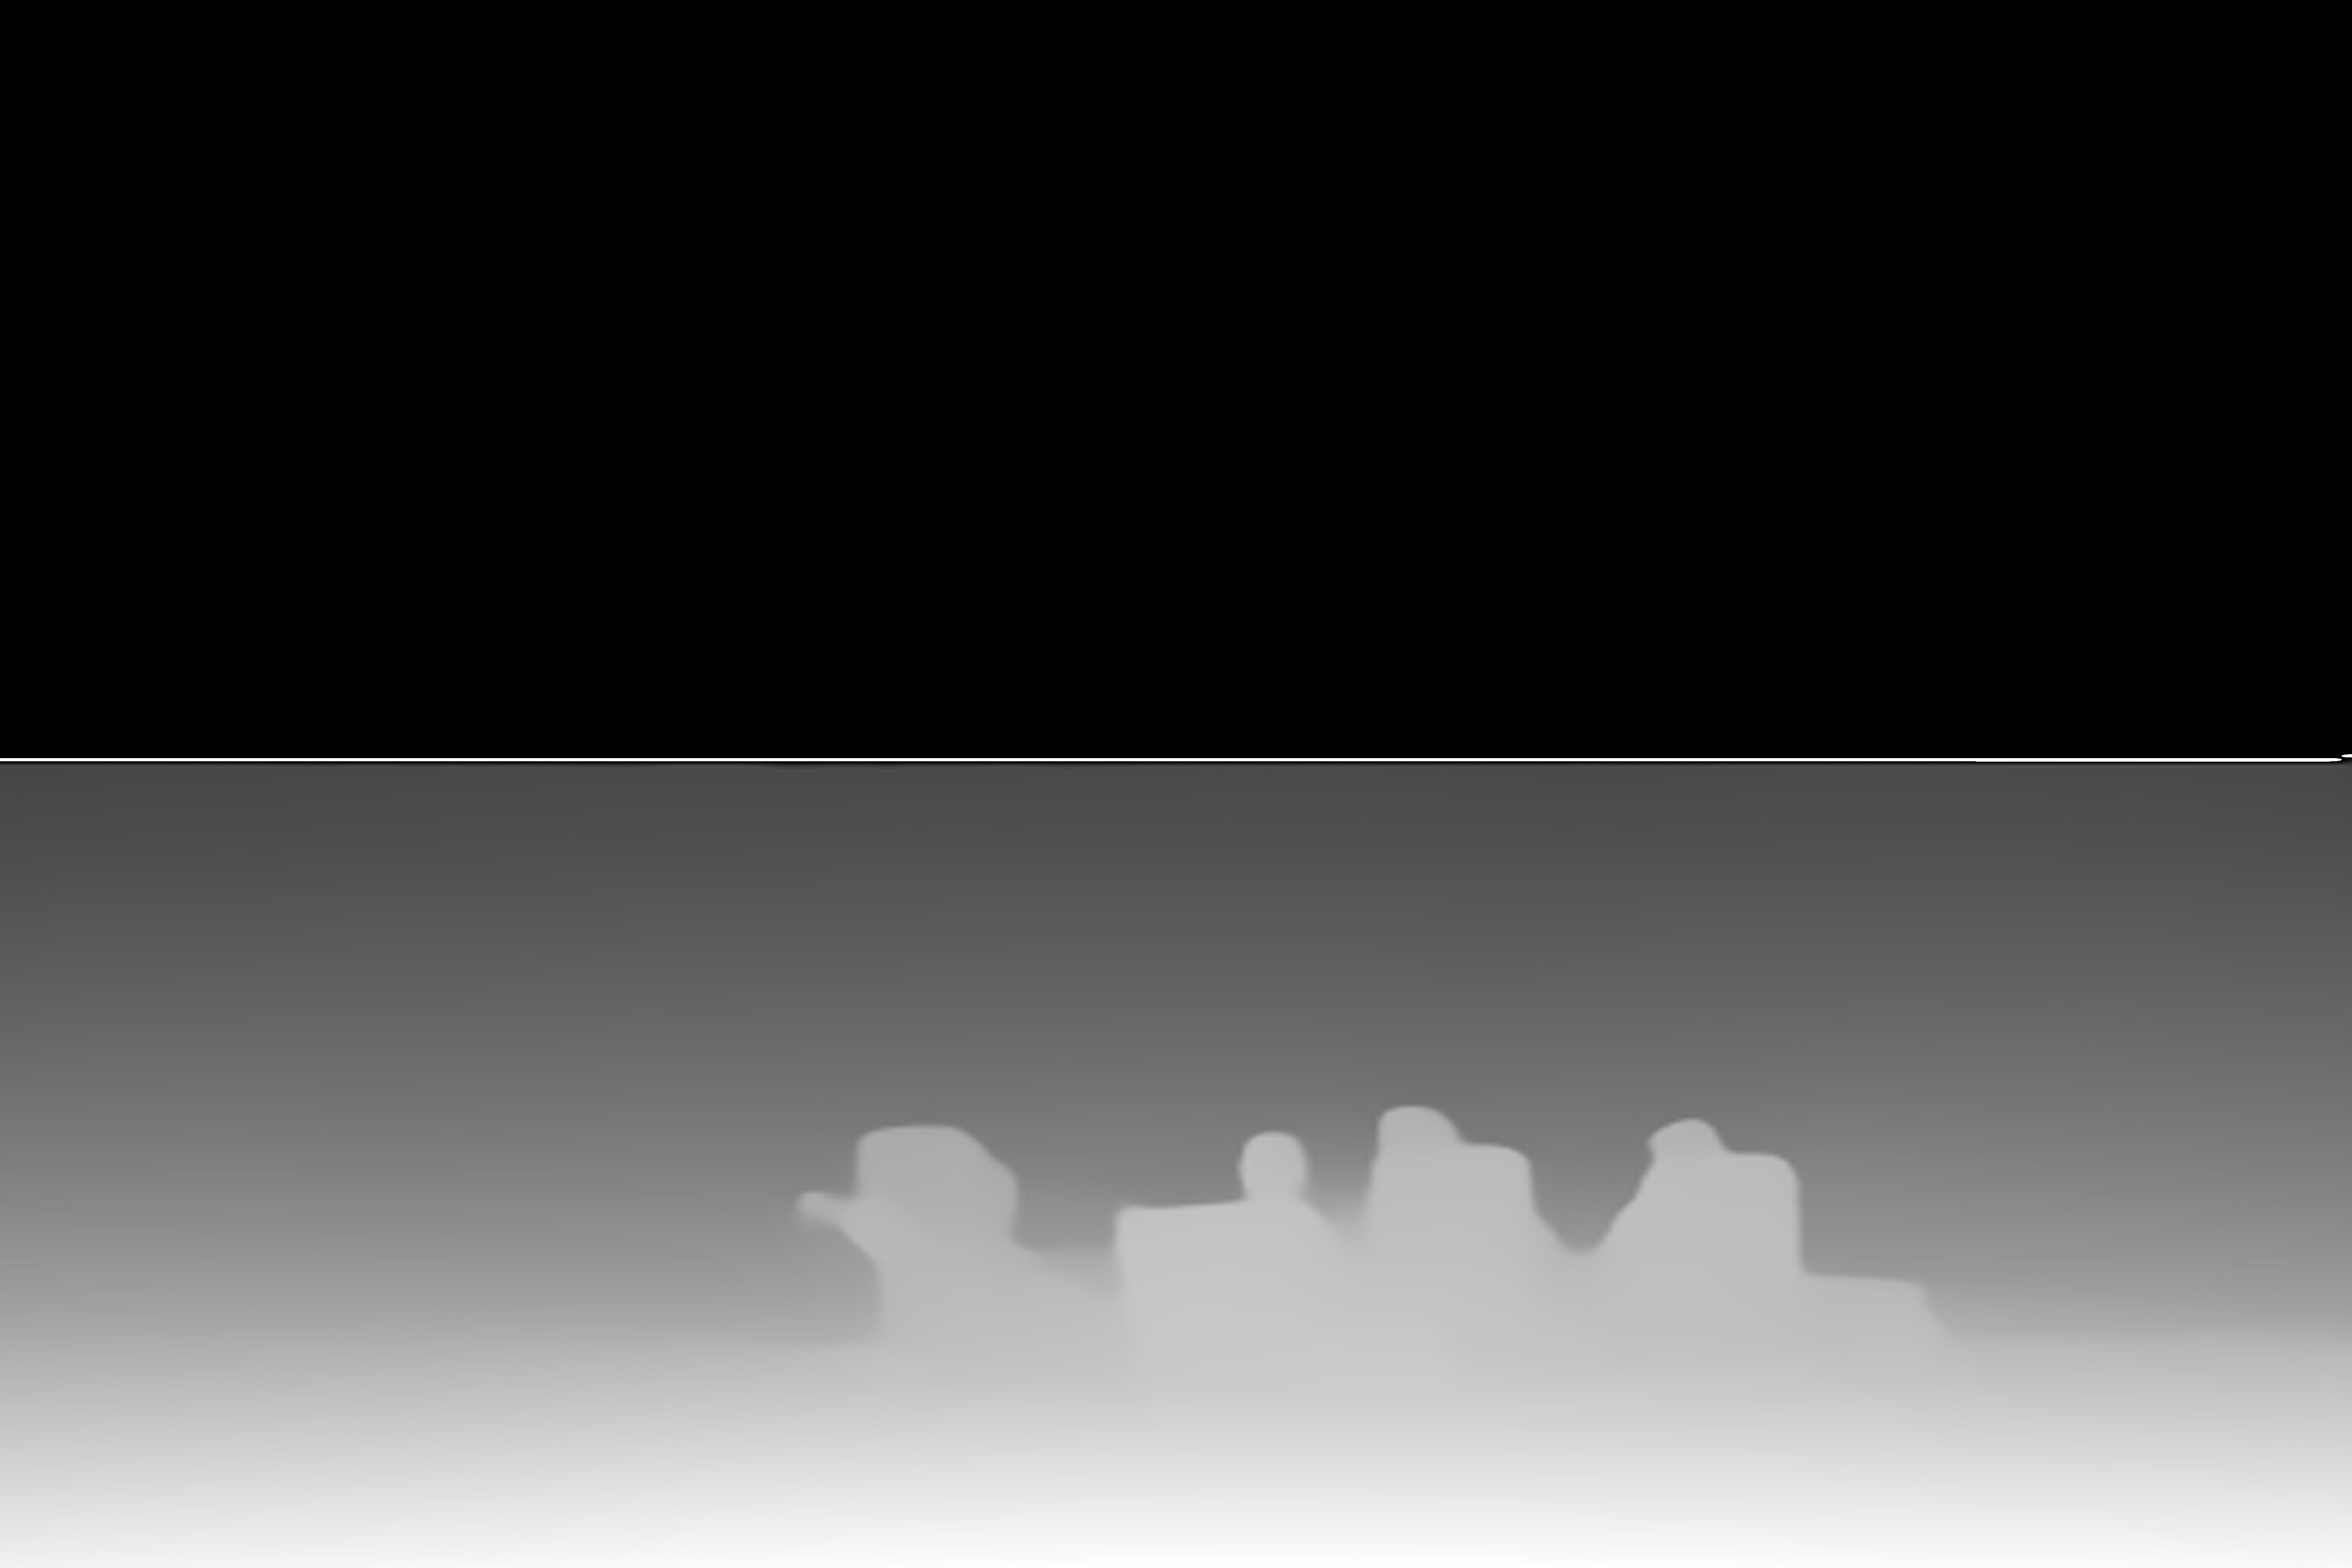

In [56]:
depth